<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>CET Template Notebook</b> <br>
Contact author(s): <i>Author Name</i> <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

_In this template, text in italics are examples or instructions that should be: (a) removed if it is not applicable to the notebook; or (b) replaced with text that is appropriate for the notebook. But bold or regular text should appear pretty much as-is in all CET notebooks. For more information, see the [CET's Guidelines for Tutorial Notebooks](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=168857070)._

_While developing, use the following code cell to check that the code conforms to standards, but then delete the cell and "Kernel --> Restart Kernel and Clear All Outputs" before saving and committing._

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

_The six cells below are considered the extended header of the notebook. The first four will be used, verbatim, to create the table of notebook metadata in the README.md file for the repository._

**Description:** _Very brief description of notebook._

**Skills:** _Brief list of skills to match the README.md file for the repository._

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:**
_E.g., "Originally developed by" or "Based on notebooks developed by" and then people's names, including journal article or software release citations if appropriate._
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

_Provide a light narrative about this notebook, e.g., "This notebook will teach the user..."._

_Cite or link to any external information or documentation, and cross-reference to other notebooks._

### 1.1 Package Imports

_All package imports should be done in the first code cell._

_Provide explanation or external links to package documentation, where appropriate._

_E.g., Numpy is a fundamental package for scientific computing with arrays in Python (<a href="https://numpy.org">numpy.org</a>)._

_Use code cell comments to describe the packages being imported._

In [16]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service, retrieve_query

# LSST package for Butler queries
import lsst.daf.butler as dafButler

# LSST package for image display
import lsst.afw.display as afwDisplay

from matplotlib import colormaps



### 1.2 Define Functions and Parameters

Import some functions from Pedro

In [17]:
import numpy as np 
from scipy.interpolate import CubicSpline
from scipy.optimize import leastsq
#Constants

A = [3.332, 1.862]
B = [0.631, 1.218]
C = [0.986, 0.238]

#values taken from sbpy for convenience

alpha_12 = np.deg2rad([7.5, 30., 60, 90, 120, 150])

phi_1_sp = [7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2, 3.6396989e-3]
phi_1_derivs = [-1.9098593, -9.1328612e-2]

phi_2_sp = [9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2, 1.6505689e-4]
phi_2_derivs = [-5.7295780e-1, -8.6573138e-8]

alpha_3 = np.deg2rad([0.0, 0.3, 1., 2., 4., 8., 12., 20., 30.])

phi_3_sp = [1., 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1, 1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.]
phi_3_derivs = [-1.0630097, 0]


phi_1 = CubicSpline(alpha_12, phi_1_sp, bc_type=((1,phi_1_derivs[0]),(1,phi_1_derivs[1])))
phi_2 = CubicSpline(alpha_12, phi_2_sp, bc_type=((1,phi_2_derivs[0]),(1,phi_2_derivs[1])))
phi_3 = CubicSpline(alpha_3, phi_3_sp, bc_type=((1,phi_3_derivs[0]),(1,phi_3_derivs[1])))


def HG_model(phase, params):
    """
    Reference: Bowell et al. (1989)
    This is the oldest 2 parameter model. 
    """
    sin_a = np.sin(phase)
    tan_ah = np.tan(phase/2)
    
    W = np.exp(-90.56 * tan_ah * tan_ah)    
    scale_sina = sin_a/(0.119 + 1.341*sin_a - 0.754*sin_a*sin_a)
    
    phi_1_S = 1 - C[0] * scale_sina
    phi_2_S = 1 - C[1] * scale_sina
    
    phi_1_L = np.exp(-A[0] * np.power(tan_ah, B[0]))
    phi_2_L = np.exp(-A[1] * np.power(tan_ah, B[1]))
    
    phi_1 = W * phi_1_S + (1-W) * phi_1_L
    phi_2 = W * phi_2_S + (1-W) * phi_2_L
    return params[0] - 2.5*np.log10((1-params[1])* phi_1 + (params[1]) * phi_2) 



def HG1G2_model(phase, params):
    """
    Reference: Muinonen et al. (2010) https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract
    This is the 3 parameter model, which works best when you have a sufficiently long phaseangle coverage.
    """

    tan_ah = np.tan(phase/2)

    phi_1_ev = phi_1(phase)  
    phi_2_ev = phi_2(phase)  
    phi_3_ev = phi_3(phase)  

    msk = phase < 7.5 * np.pi/180

    phi_1_ev[msk] = 1-6*phase[msk]/np.pi 
    phi_2_ev[msk] = 1- 9 * phase[msk]/(5*np.pi)

    phi_3_ev[phase > np.pi/6] = 0


    return params[0] - 2.5 * np.log10(params[1] * phi_1_ev + params[2] * phi_2_ev + (1-params[1]-params[2]) * phi_3_ev)

def HG12_model(phase, params): 
    """
    Reference:
    Muinonen et al. (2010) https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract
    This is a simplified version of HG1G2. It's more useful when phaseangle coverage is shorter.
    """
    if params[1] >= 0.2:
        G1 = +0.9529*params[1] + 0.02162 
        G2 = -0.6125*params[1] + 0.5572
    else:
        G1 = +0.7527*params[1] + 0.06164  
        G2 = -0.9612*params[1] + 0.6270

    return HG1G2_model(phase, [params[0], G1, G2])

def chi2(params, mag, phase, mag_err, model):
    pred = model(phase, params)
    return (mag - pred)/mag_err

def fit(mag, phase, sigma, model=HG12_model, params=[0.1]):
    phase = np.deg2rad(phase)


    sol = leastsq(chi2, [mag[0]] + params,  (mag, phase, sigma, model), full_output = True)

    return sol




In [18]:
def fit_models(mag, magSigma, phaseAngle, tdist, rdist):

    # correct the mag to 1AU distance
    dmag = -5. * np.log10(tdist*rdist)
    mag = mag + dmag

    #double check if this is needed
    #phaseAngle = np.deg2rad(phaseAngle)

    # now we'll fit using each one of the HG, HG12 and HG1G2 models and store these in a dictionary of dictionaries
    solutions = {}

    #Let's do HG first
    sol_HG = fit(mag, phaseAngle, magSigma, model=HG_model)

    solutions['HG'] = {}

    solutions['HG']['chi2'] = np.sum(sol_HG[2]['fvec']**2)
    solutions['HG']['H'] = sol_HG[0][0]
    solutions['HG']['G'] = sol_HG[0][1]
    solutions['HG']['H_err'] = np.sqrt(sol_HG[1][0,0])
    solutions['HG']['G_err'] = np.sqrt(sol_HG[1][1,1])
    solutions['HG']['cov'] = sol_HG[1]
            

    # now HG12
    sol_HG12 = fit(mag, phaseAngle, magSigma, model=HG12_model)

    solutions['HG12'] = {}

    solutions['HG12']['chi2'] = np.sum(sol_HG12[2]['fvec']**2)
    solutions['HG12']['H'] = sol_HG12[0][0]
    solutions['HG12']['G12'] = sol_HG12[0][1]
    solutions['HG12']['H_err'] = np.sqrt(sol_HG12[1][0,0])
    solutions['HG12']['G12_err'] = np.sqrt(sol_HG12[1][1,1])
    solutions['HG12']['cov'] = sol_HG12[1]

    # finally, HG1G2 - note this returns an extra parameter

    # now HG12, let's tell the code we need that extra parameter
    sol_HG1G2 = fit(mag, phaseAngle, magSigma, model=HG1G2_model, params=[0.1, 0.1])

    solutions['HG1G2'] = {}

    solutions['HG1G2']['chi2'] = np.sum(sol_HG1G2[2]['fvec']**2)
    solutions['HG1G2']['H'] = sol_HG1G2[0][0]
    solutions['HG1G2']['G1'] = sol_HG1G2[0][1]
    solutions['HG1G2']['G2'] = sol_HG1G2[0][1]
    solutions['HG1G2']['H_err'] = np.sqrt(sol_HG1G2[1][0,0])
    solutions['HG1G2']['G1_err'] = np.sqrt(sol_HG1G2[1][1,1])
    solutions['HG1G2']['G2_err'] = np.sqrt(sol_HG1G2[1][2,2])

    solutions['HG1G2']['cov'] = sol_HG1G2[1]
    return solutions

## 2. Section Heading

_Use numbers for sections, sub-sections, and sub-sub-sections to enable referencing, e.g., "I'm having trouble with the second code cell in Section 2.3."_

_Use section titles that actively describe what is being done, e.g., "Create a color-magnitude diagram" instead of "Plot", so that the auto-generated table of contents is easy to navigate._

### 2.1 Section Sub-heading

#### 2.1.1 Section Sub-sub-heading

In [19]:
service = get_tap_service("ssotap")

# select by NEO to get a larger range of orbital 
# need perihelion distance < 1 AU in MPCORB and on nobs is a lot? Or, select on long value of arc

# Need to check that the phase angle units in radians vs degrees. Function above by Pedro
# assumes they will be in degrees so may need to convert (check if goes to 90 or pi)

# need apparent magnitudes & uncertainties, phase angle topocentric (tdist) and heliocentric (rdist) distances & uncertainties (but they are 0; from SSSource)
#fitHG12 returns the absmag and phase coeff (G12) These will all be per band

# could also do the query using LEFT JOIN (i.e. specify a reference catalog to improve
# efficiency of the query)

In [59]:
# Getting a list of ssObjectID for sources with perihelion distance < 1 AU and arc longer than 3000 days 
# to have sufficient phase angle coverage.
query0 = "SELECT mpc.ssObjectId, mpc.q, sso.ssObjectId, sso.arc, " + \
        "sso.uH, sso.uHerr, sso.uG12, sso.uG12err, " + \
        "sso.gH, sso.gHerr, sso.gG12, sso.gG12err, " + \
        "sso.rH, sso.rHerr, sso.rG12, sso.rG12err, " + \
        "sso.iH, sso.iHerr, sso.iG12, sso.iG12err, " + \
        "sso.zH, sso.zHerr, sso.zG12, sso.zG12err, " + \
        "sso.yH, sso.yHerr, sso.yG12, sso.yG12err " + \
        "FROM dp03_catalogs.MPCORB as mpc " + \
        "INNER JOIN dp03_catalogs.SSObject as sso " + \
        "ON mpc.ssObjectId = sso.ssObjectId " + \
        "WHERE sso.numObs > 300 AND sso.arc > 3000 "  + \
        "AND mpc.q < 1 ORDER by sso.arc"

df0 = service.search(query0).to_table()
df0

ssObjectId,q,ssObjectId2,arc,uH,uHerr,uG12,uG12err,gH,gHerr,gG12,gG12err,rH,rHerr,rG12,rG12err,iH,iHerr,iG12,iG12err,zH,zHerr,zG12,zG12err,yH,yHerr,yG12,yG12err
,AU,,days,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
7715686124374063765,0.571065676945,7715686124374063765,3002.7124,18.90946,0.0043053715,0.1608448,0.002444223,17.378702,0.0027190791,0.16151895,0.0015305596,16.714846,0.0018636519,0.15415351,0.0010499314,16.495907,0.0014645538,0.14409728,0.00080861215,16.550474,0.0020617582,0.1441396,0.0012063707,16.54686,0.0022156273,0.14521246,0.0011194511
-8780660183998289281,0.820917810849,-8780660183998289281,3004.073,17.943047,0.003435604,0.1319347,0.002909414,16.428194,0.0020551125,0.14233191,0.0011944234,15.778479,0.0010629223,0.14242189,0.00069887086,15.578641,0.0008598937,0.14269847,0.0004986182,15.640499,0.0017590912,0.14727227,0.0009851776,15.638181,0.002484336,0.14797649,0.0014223099
-8396876516603990761,0.418218052963,-8396876516603990761,3008.6653,--,--,--,--,19.36406,0.0023286364,0.13178268,0.0026904028,18.716324,0.0016103638,0.13308255,0.001770967,18.523846,0.00088433677,0.14102454,0.0007487681,18.595655,0.006199951,0.14965267,0.002953262,18.570574,0.0009961161,0.14045364,0.0006569257
-5696324832212391882,0.895456946306,-5696324832212391882,3014.6917,21.189829,0.32051426,0.20681505,0.2143256,19.527521,0.0038084248,0.13452598,0.0030609749,18.88032,0.0038285942,0.1345948,0.0031471518,18.675367,0.0057876376,0.13239554,0.0049451995,18.725496,0.009042079,0.124834396,0.007938425,18.712135,0.025097558,0.1236046,0.017989833
7679944747240041758,0.840474265631,7679944747240041758,3022.1682,21.468689,0.1359462,0.09719814,0.07827226,20.04137,0.016985144,0.16374041,0.0097732395,19.37782,0.00919161,0.15393928,0.00532,19.184336,0.018791627,0.15867557,0.010729314,19.18976,0.015509653,0.13068925,0.008929713,19.239641,0.034168627,0.16324636,0.020700412
4031067060225681921,0.516501056815,4031067060225681921,3022.6965,--,--,--,--,20.432327,0.020913607,0.14906831,0.015531123,19.763157,0.0105768675,0.13901448,0.008295496,19.565521,0.01279993,0.1393641,0.009827861,19.586174,0.028865777,0.11401525,0.018935781,19.46163,0.124143235,0.06434943,0.060525313
5789538255677276403,0.915375468201,5789538255677276403,3023.7039,20.711811,0.06993432,0.18250193,0.07832042,19.170547,0.0145315975,0.15215416,0.014929708,18.523186,0.006325249,0.15399528,0.006374759,18.312649,0.0059254435,0.14433254,0.004208886,18.356674,0.01097433,0.13551377,0.0082622515,18.387228,0.029069629,0.16298378,0.028573383
1573590504143555372,0.513909734279,1573590504143555372,3025.6282,20.15517,0.036408614,0.15484202,0.022919487,18.621355,0.0040895464,0.14331573,0.0024201337,17.973162,0.0014758252,0.14535415,0.00084397173,17.781563,0.0027079,0.14965132,0.0014599088,17.833742,0.0054859472,0.14916967,0.0033518458,17.838442,0.006110435,0.1536164,0.0032637147


In [60]:
# Object from Meg's notebook: -9223369546614897710
ssObjId = df0['ssObjectId'][-3] 

# diaObjectId is the ID that links the individual measurements between DiaObject and SSSource,
# so you have to match on this id for unique measurement matching. 
# To then match this object to MPCORB and SSObject, you have
# to link on the SSObjectID (hwich is unique per solar system object)

query = "SELECT dia.diaSourceId, sss.diaSourceId, dia.mag, " + \
        "dia.magSigma, dia.filter, sss.phaseAngle, sss.topocentricDist, " + \
        "sss.heliocentricDist, dia.midPointTai " + \
        "FROM dp03_catalogs.DiaSource as dia " + \
        "JOIN dp03_catalogs.SSSource as sss " + \
        "ON dia.diaSourceId = sss.diaSourceId " + \
        "WHERE dia.ssObjectId = " + str(ssObjId) + ""


df = service.search(query).to_table()
print(len(df))

381


In [ ]:
# # first character is the filter.
# # NOTE: In the ssObjectTable, the column G12 is correct in that the final table
# # should contain the parameter G12, however, the existing version of the column
# # actually contains parameter G (and therefore should be compared to the HG_model
# # not HG12 model. The plan is to replace the contents of G12 column with actual G12
# # fit parameters in the final version
# query2 = "SELECT ssObjectId, rH, rHerr, rG12, rG12err, " + \
#          "iH, iHerr, iG12, iG12err " + \
#          "FROM dp03_catalogs.SSObject  " + \
#          "WHERE ssObjectId = " + str(ssObjId) + " "

# df2 = service.search(query2).to_table()
# print(df2)

What is the absolute magnitude? The measured magnitude (apparent magnitude) of a Solar System object depends on the incident light from the Sun, in addition to the distance to the observer (as is usual for sources outside the Solar System). So to convert from the apparent magnitude to the reduced magnitude, one factors in this reduction in flux, conventionally bringing both distances to 1 au so the convertion becomes a factor of -5log10 ( heliocentric distance * topocentric distance). There is also the question of the illumination angle, so that a higher phase angle means that a smaller fraction of the object's surface is being illuminated (I think that link @Yumi Choi sent earlier this week is the most accessible I've seen). The absolute magnitude is the magnitude at 1 au from the Sun, 1 au from the observer and at 0 phase angle (note this is an unphysical situation: an object will never satisfy these 3 conditions simultaneously). Typically then one fits the absolute magnitude with an assumed phase curve model (eg the HG or HG12 models). That Muinonen et al (2010) paper goes over in detail.

In [61]:
filts = np.unique(df['filter'])

for ifilt in filts:
    nobs_ifilt = len(df[df['filter']==ifilt])
    print('Number of measurements in %s: %d' % (ifilt, nobs_ifilt))

Number of measurements in g: 40
Number of measurements in i: 98
Number of measurements in r: 95
Number of measurements in u: 14
Number of measurements in y: 53
Number of measurements in z: 81


In [62]:
tdist = df['topocentricDist']
rdist = df['heliocentricDist']
dmag = -5. * np.log10(tdist*rdist)

reduced_mag = df['mag']+dmag

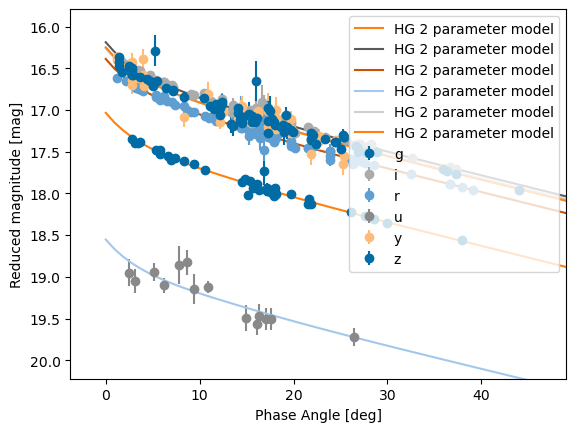

In [63]:
for ifilt in filts:
    idx = df['filter'] == ifilt
    
    plt.errorbar(df['phaseAngle'][idx], reduced_mag[idx], yerr=df['magSigma'][idx], fmt='o', label=ifilt)
    x = fit_models(df['mag'][idx], df['magSigma'][idx], df['phaseAngle'][idx], tdist[idx], rdist[idx])


    phases = np.linspace(0,90,100)
    HG12_mag = HG12_model(np.deg2rad(phases), [x['HG12']['H'], x['HG12']['G12']])
    HG_mag = HG_model(np.deg2rad(phases), [x['HG']['H'], x['HG']['G']])
    HG1G2_mag = HG1G2_model(np.deg2rad(phases), [x['HG1G2']['H'], x['HG1G2']['G1'], x['HG1G2']['G2']])

    plt.plot(phases, HG_mag, label ='HG 2 parameter model')
    
plt.xlim(df['phaseAngle'].min()-5, df['phaseAngle'].max()+5)
plt.ylim(reduced_mag.max()+0.5, reduced_mag.min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend()

Junk Code Below

     ssObjectId         rH       rHerr    ...    iG12      iG12err   
                       mag        mag     ...    mag         mag     
------------------- --------- ----------- ... ---------- ------------
9195611452849605128 16.388489 0.003104142 ... 0.14243123 0.0027389626


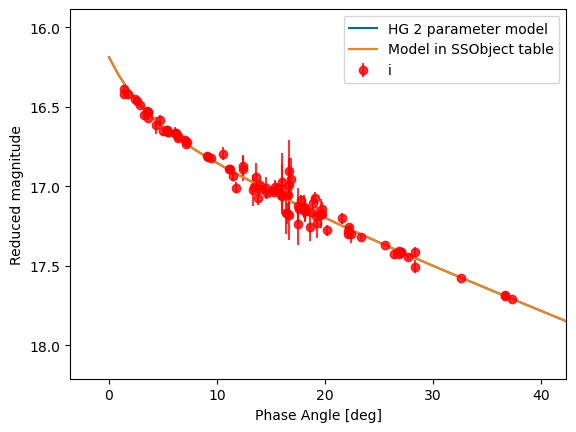

In [25]:
whr = np.where(df['filter'] == 'r')[0]
whz = np.where(df['filter'] == 'z')[0]
whi = np.where(df['filter'] == 'i')[0]
whg = np.where(df['filter'] == 'g')[0]
print(df['magSigma'][whr])

whband = whi

# Include these for distance correction to Reduced magnitude:
tdist = df['topocentricDist']
rdist = df['heliocentricDist']
dmag = -5. * np.log10(tdist*rdist)


#plt.errorbar(df['phaseAngle'][whr], df['mag'][whr]+dmag[whr], yerr=df['magSigma'][whr],fmt='o', alpha=.8,label='r band')
#plt.errorbar(df['phaseAngle'][whz], df['mag'][whz]+dmag[whz], yerr=df['magSigma'][whz],fmt='o', alpha=.8,label='z')
plt.errorbar(df['phaseAngle'][whband], df['mag'][whband]+dmag[whband], yerr=df['magSigma'][whband],fmt='ro', alpha=.8,label='i')
#plt.errorbar(df['phaseAngle'][whg], df['mag'][whg]+dmag[whg], yerr=df['magSigma'][whg],fmt='ok', alpha=.8,label='g')

#plt.ylim((np.max(df['mag'][whr]+dmag[whr])+.1,np.min(df['mag'][whr]+dmag[whr])-1.5))
plt.ylim(np.max(df['mag'][whband]+dmag[whband])+0.5, np.min(df['mag'][whband]+dmag[whband])-0.5)
plt.xlim(np.min(df['phaseAngle'][whband])-5, np.max(df['phaseAngle'][whband])+5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude')

#print(df['mag'][whr], df['phaseAngle'][whr])
#print(len(whr))
#print(np.unique(df['filter']))


#x = fit_models(df['mag'][whr], df['magSigma'][whr], df['phaseAngle'][whr], df['topocentricDist'][whr], df['heliocentricDist'][whr])
x = fit_models(df['mag'][whband], df['magSigma'][whband], df['phaseAngle'][whband], df['topocentricDist'][whband], df['heliocentricDist'][whband])


phases = np.linspace(0,90,100)
HG12_mag = HG12_model(np.deg2rad(phases), [x['HG12']['H'], x['HG12']['G12']])
HG_mag = HG_model(np.deg2rad(phases), [x['HG']['H'], x['HG']['G']])
HG1G2_mag = HG1G2_model(np.deg2rad(phases), [x['HG1G2']['H'], x['HG1G2']['G1'], x['HG1G2']['G2']])

plt.plot(phases, HG_mag, label ='HG 2 parameter model')
#plt.plot(phases, HG12_mag, label='HG12 2 parameters model')
#plt.plot(phases, HG1G2_mag, label='HG1G2 3 parameter model')

# first character is the filter.
# NOTE: In the ssObjectTable, the column G12 is correct in that the final table
# should contain the parameter G12, however, the existing version of the column
# actually contains parameter G (and therefore should be compared to the HG_model
# not HG12 model. The plan is to replace the contents of G12 column with actual G12
# fit parameters in the final version
query2 = "SELECT ssObjectId, rH, rHerr, rG12, rG12err, " + \
         "iH, iHerr, iG12, iG12err " + \
        "FROM dp03_catalogs.SSObject  " + \
        "WHERE ssObjectId = " + str(ssObjId) + " "

df2 = service.search(query2).to_table() # .to_pandas()
print(df2)

#HG12_mag_sso = HG12_model(np.deg2rad(phases), [df2['rH'], df2['rG12']])
#HG12_mag_sso = HG12_model(np.deg2rad(phases), [df2['iH'], df2['iG12']])
#HG_mag = HG_model(np.deg2rad(phases), [x['HG']['H'], x['HG']['G']])
HG_mag_sso = HG_model(np.deg2rad(phases), [df2['iH'], df2['iG12']])
#HG1G2_mag = HG1G2_model(np.deg2rad(phases), [x['HG1G2']['H'], x['HG1G2']['G1'], x['HG1G2']['G2']])

plt.plot(phases, HG_mag_sso, label ='Model in SSObject table')

plt.legend()


In [12]:
#query1 = "SELECT mpc.ssObjectId, mpc.q, sso.ssObjectId, sso.arc " + \
#        "FROM dp03_catalogs.MPCORB as mpc " + \
#        "INNER JOIN dp03_catalogs.SSObject as sso " + \
#        "ON mpc.ssObjectId = sso.ssObjectId " + \
#        "INNER JOIN dp03_catalogs.DiaSource as dia " + \
#        "ON mpc.ssObjectId = dia.ssObjectId " + \
#        "INNER JOIN dp03_catalogs.SSSource as sss " + \
#        "ON mpc.ssObjectId = sss.ssObjectId " + \
#        "WHERE mpc.ssObjectId > 1  AND sso.arc > 3000 "  + \
#        "AND mpc.q < 1 ORDER by sso.arc"

#query = "SELECT TOP 10000 * FROM dp03_catalogs.SSObject WHERE arc > 3000 ORDER by arc"
#df = service.search(query).to_table().to_pandas()
#df

In [13]:
#query = "SELECT TOP 10000 * FROM dp03_catalogs.MPCORB WHERE q < 1 ORDER by arc"

# this takes too long:
#query = "SELECT mpc.ssObjectId, mpc.q, sso.ssObjectId, sso.arc " + \
#        "FROM dp03_catalogs.MPCORB as mpc " + \
#        "JOIN dp03_catalogs.SSObject as sso " + \
#        "ON mpc.ssObjectId = sso.ssObjectId " + \
#        "JOIN dp03_catalogs.DiaSource as dia " + \
#        "ON mpc.ssObjectId = dia.ssObjectId " + \
#        "JOIN dp03_catalogs.SSSource as sss " + \
#        "ON mpc.ssObjectId = sss.ssObjectId " + \
#        "WHERE mpc.ssObjectId > 1  AND sso.arc > 3000 "  + \
#        "AND mpc.q < 1 ORDER by sso.arc"


In [14]:

#query = "SELECT mpc.ssObjectId, mpc.q, sso.ssObjectId, sso.arc, dia.mag," + \
#        "dia.magSigma, dia.filter, sss.phaseAngle, sss.topocentricDist, " + \
#        "sss.heliocentricDist, dia.midPointTai " + \
#        "FROM dp03_catalogs.MPCORB as mpc " + \
#        "JOIN dp03_catalogs.SSObject as sso " + \
#        "ON mpc.ssObjectId = sso.ssObjectId " + \
#        "JOIN dp03_catalogs.DiaSource as dia " + \
#        "ON mpc.ssObjectId = dia.ssObjectId " + \
#        "JOIN dp03_catalogs.SSSource as sss " + \
#        "ON mpc.ssObjectId = sss.ssObjectId " + \
#        "WHERE sss.ssObjectId = 3728357697728353090"
